# Part 2 Monte Carlo methods

### Monte Carlo prediction
In Monte Carlo methods, the value function of a state is estimated by the average of the returns following *each visit* or *each first visit* to that state in a set of episodes. 

#### Incremental updates
Incremental mean: 
$$\mu_k=\frac{1}{k}\sum_{j=1}^kx_j=\mu_{k-1}+\frac{1}{k}(x_k-\mu_{k-1})$$

Incremental MC updates: 
$$v^j(s_t)=v^{j-1}(s_t)+\frac{1}{N(s_t)}(G^j_t-v^{j-1}(s_t))$$

where $G^j_t$ is the total return at j'th episode and $N(s_t)$ is the number of times state $s_t$ was visited - **the every-visit MC method**.

### Example: Blackjack
Blackjack is a card game. The goal is to obtain cards the sum of whose numerical values is as large as possible without exceeding 21. The face cards (JQK) count as 10 and the ace can count either as 1 or as 11. Consider the version in which each player competes independently against the dealer.  The game begins with 2 cards dealt to both dealer and player. One of the dealer's card is shown and the other is hidden. If the player has 21 immediately, it is called a natural. She then wins unless the dealer also has a natural. In that case, the game is a draw. If the player doesn't start with a natural, she can choose to either 'hit' or 'stick'. If the cards in hand exceeds 21, she loses. If she hits, she receives another card. If she sticks, it becomes the dealer's turn. 

This environment has been built in Gym, which is defined as following:
- Each game is an episode
- The cards are drawn from $\mathrm{deck}\in\{1,2,3,4,5,6,7,8,9,10,10,10,10\}$ with replacement
- The two actions are $a\in\{hit=1,stick=0\}$
- The rewards for win, draw and lose are $r\in\{+1,0,-1\}$
- The observation space has 3 variables: the players current sum,
the dealer's one showing card (1-10 where 1 is ace), and whether or not the player holds a usable ace (0 or 1).

We first consider a simple policy which chooses to hit when the sum of the player's cards in hand is equal to or less than 20 otherwise stick and evaluate it using the every-visit MC method. 

In [2]:
def policy(hand_sum):
    if hand_sum > 20:
        return 0
    else:
        return 1
    
def mc_policy_evaluation(state_count, r, value):
    return value + (r - value) / state_count


The player makes decisions on the basis of the three variables in the observation space: current sum (12-21), the dealer's one showing card (1-10) and whether or not she has a usable ace. Here, we focus on the setting where the current sum is at least 12. If it is smaller than 12, hit would be the optimal action. This makes for a total of 200 states. We therefore create two matrices to store the states for the two situations - with ace and without ace.  The row in each matrix indicates the player's cards and the column indicates the dealer's card.  

Import the environment and create arrays to store the state values and the number of appearances of each states, 


In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(123)

env = gym.make('Blackjack-v1', natural=False, sab=False)
values_usable_ace = np.zeros((10, 10))
values_no_usable_ace = np.zeros_like(values_usable_ace)
state_count_ace = np.zeros_like(values_usable_ace)
state_count_no_ace = np.zeros_like(state_count_ace)
episodes = 10000

Play the game for a number of episodes, count the state visits and record the observations and rewards:


In [4]:
for e in range(episodes):
        done = False
        obs = env.reset()
        state_history = []
        g = []
        
        obs = obs[0]
#        if obs[0] <= 11:
#            done = True   
        if obs[0] > 11:
            state_history.append(obs)

            while not done:
                a = policy(obs[0])
                obs, r, done, info, prob = env.step(a)
                g.append(r)
                if done:
                    break
                state_history.append(obs)

            final_reward = sum(g)

            for player_idx, dealer_idx, ace in state_history:
                player_idx -= 12
                dealer_idx -= 1

                if ace:
                    state_count_ace[player_idx, dealer_idx] += 1.0
                    values_usable_ace[player_idx, dealer_idx] = mc_policy_evaluation(state_count_ace[player_idx, dealer_idx],
                                                                                     final_reward,
                                                                                     values_usable_ace[player_idx, dealer_idx])
                else:
                    state_count_no_ace[player_idx, dealer_idx] += 1.0
                    values_no_usable_ace[player_idx, dealer_idx] = mc_policy_evaluation(state_count_no_ace[player_idx, dealer_idx],
                                                                                         final_reward,
                                                                                         values_no_usable_ace[player_idx, dealer_idx])

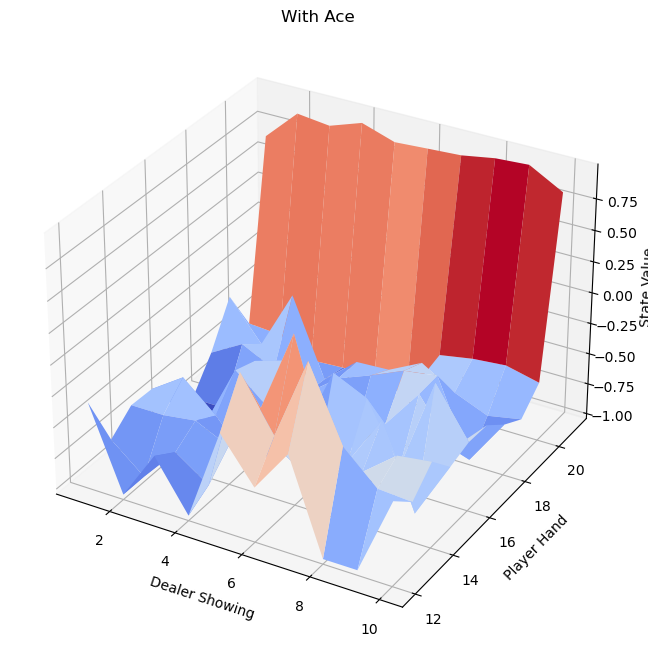

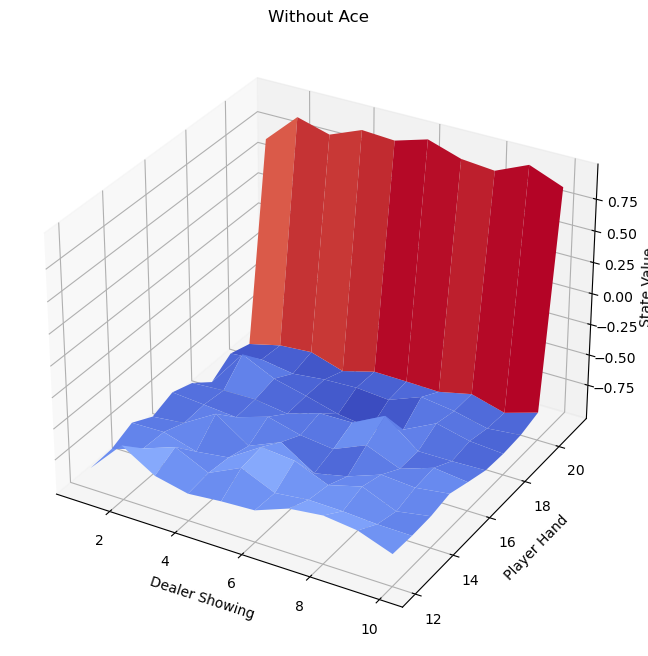

In [5]:
def plot_v(values, ace=True):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(projection='3d')

    x = np.arange(12, 22)
    y = np.arange(1, 11)

    X, Y = np.meshgrid(y, x)

    Z = values.reshape(X.shape)

    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=1, rstride=1, cstride=1)
    if ace:
        ax.set_title("With Ace")
    else:
        ax.set_title("Without Ace")
    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Hand")
    ax.set_zlabel("State Value")
    plt.show()

plot_v(values_usable_ace)
plot_v(values_no_usable_ace, ace=False)

### We next implement the MC control algorithm with exploring starts in the Blackjack example and visualise the resulting optimal policy

<img src="./graphs/MCcontrol0.png" width="800" height="500"/>

Firstly, import the environment and create Numpy arrays to store the value and the number of appearance for every state-action pair,

In [6]:
player = 10
dealer = 10
n_action = 2
qsa_with_ace = np.zeros([player, dealer, n_action])
qsa_without_ace = np.zeros_like(qsa_with_ace)
a_s_counts_ace = np.zeros_like(qsa_with_ace)
a_s_counts_no_ace = np.zeros_like(a_s_counts_ace)

Initialise the policy: stick if the sum of player's cards >= 18 (action = 0), else hit

In [7]:
policy_with_ace = np.ones([player, dealer], dtype=int)
policy_with_ace[7:, :] = 0
policy_without_ace = np.ones([player, dealer], dtype=int)
policy_without_ace[7:, :] = 0

episodes = 500000
epsilon = 0.1

Run a certain number of episodes, evaluate and update the current policy after each episode, 


In [8]:
def plot_policy(policy, ace=True):
    # Get colors
    cmap = plt.cm.get_cmap("Paired")
    colors = list([cmap(0.2), cmap(0.8)])
    label = ["Stick", "Hit"]

    # Plot results
    plt.figure(figsize=(15, 6))

    player_range = np.arange(11, 22)
    dealer_range = np.arange(0, 11)

    plt.pcolor(dealer_range, player_range, policy, label=label, cmap=mpl.colors.ListedColormap(colors))
    plt.axis([dealer_range.min(), dealer_range.max(), player_range.min(), player_range.max()])
    col_bar = plt.colorbar()
    col_bar.set_ticks([0.25, 0.75])
    col_bar.set_ticklabels(label)
    plt.grid()
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Score")
    if ace:
        plt.title("Optimal Policy With a Usable Ace ($\pi_*$)")
    else:
        plt.title("Optimal Policy Without a Usable Ace ($\pi_*$)")
    plt.show()

/var/folders/97/mt8hzhgd13gffjkx7hcvhzq80000gp/T/ipykernel_50642/1806132942.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Paired")


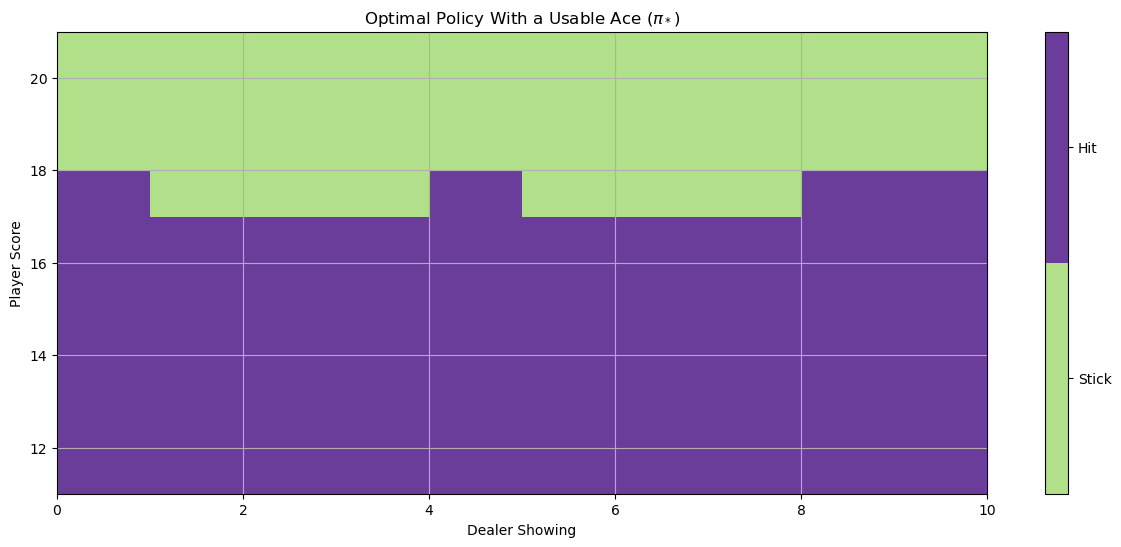

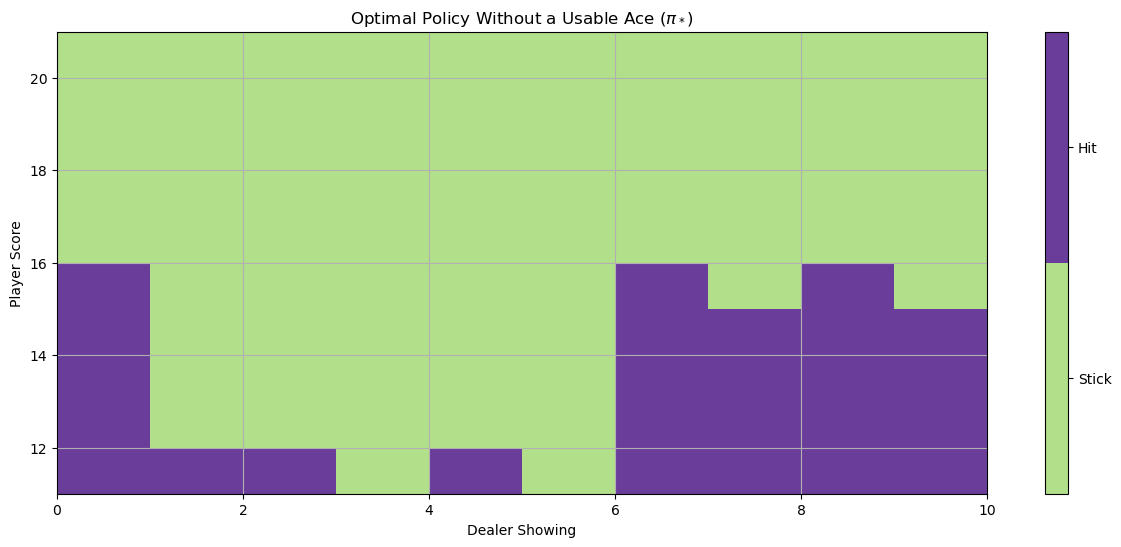

In [9]:
def policy_evaluation(counts, qsa, g):
    return qsa + (g - qsa) / counts

for e in range(episodes + 1):
    done = False
    obs = env.reset()
    state_action_history = []
    g = []
    # random first action
    a = env.action_space.sample()

    obs = obs[0]
#    if obs[0] <= 11:
#        done = True
#    else:    
#        state_action_history.append([obs[0], obs[1], obs[2], a])
    if obs[0] > 11:
        state_action_history.append([obs[0], obs[1], obs[2], a])

        while not done:
            obs, r, done, info, prob = env.step(a)
            g.append(r)
            if done:
                break
            current_player_idx = obs[0] - 12
            current_dealer_idx = obs[1] - 1
            if obs[2]:
                a = policy_with_ace[current_player_idx, current_dealer_idx]
            else:
                a = policy_without_ace[current_player_idx, current_dealer_idx]

            state_action_history.append([obs[0], obs[1], obs[2], a])

        final_reward = sum(g)
        for player_idx, dealer_idx, ace, action in state_action_history:
            player_idx -= 12
            dealer_idx -= 1

            if ace:
                a_s_counts_ace[player_idx, dealer_idx, action] += 1.0
                qsa_with_ace[player_idx, dealer_idx, action] = policy_evaluation(a_s_counts_ace[player_idx, dealer_idx, action],
                                                                            qsa_with_ace[player_idx, dealer_idx, action],
                                                                            final_reward)
                # improve policy
                policy_with_ace[player_idx, dealer_idx] = np.argmax(qsa_with_ace[player_idx, dealer_idx])

            else:
                a_s_counts_no_ace[player_idx, dealer_idx, action] += 1.0
                qsa_without_ace[player_idx, dealer_idx, action] = policy_evaluation(a_s_counts_no_ace[player_idx, dealer_idx, action],
                                                                               qsa_without_ace[player_idx, dealer_idx, action],
                                                                               final_reward)
                policy_without_ace[player_idx, dealer_idx] = np.argmax(qsa_without_ace[player_idx, dealer_idx])
            
plot_policy(policy_with_ace)
plot_policy(policy_without_ace, ace=False)